# Qiskit Scratch Work
This notebook contains scratch work from learning how to IMB's quantum Qiskit package.

In [60]:
from collections import defaultdict
from dotenv import load_dotenv
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import Estimator, EstimatorV2, SamplerV2 as Sampler
from qiskit.circuit.library import QAOAAnsatz
from qiskit.primitives import StatevectorEstimator, StatevectorSampler
from qiskit.quantum_info import Pauli, SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorOptions, EstimatorV2, QiskitRuntimeService, Session
from rustworkx.visualization import mpl_draw as draw_graph
from scipy.optimize import minimize
from typing import Sequence
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import qiskit
import rustworkx as rx

load_dotenv()
API_TOKEN = os.getenv("API_TOKEN")
matplotlib.rcParams.update({"font.size": 10})

## Install Qiskit
This section follows the installation section from the [IBM Quantum Documentation](https://docs.quantum.ibm.com/guides/install-qiskit).

In [2]:
qiskit.__version__

'1.3.1'

In [3]:
service = QiskitRuntimeService(channel="ibm_quantum", token=API_TOKEN)

"""AccountAlreadyExistsError: 'Named account (default-ibm-quantum) already exists. Set overwrite=True to overwrite.'"""
# QiskitRuntimeService.save_account(channel="ibm_quantum", token=API_TOKEN) 

backend = service.backend(name="ibm_brisbane")

In [4]:
backend.num_qubits

127

## Create your first quantum program in Qiskit
This section follows the `README.md` from the [GitHub repo](https://github.com/Qiskit/qiskit).

In [5]:
# 1. A quantum circuit for preparing the quantum state |000> + i |111>
qc_example = QuantumCircuit(3)
qc_example.h(0)          # generate superpostion
qc_example.p(np.pi/2,0)  # add quantum phase
qc_example.cx(0,1)       # 0th-qubit-Controlled-NOT gate on 1st qubit
qc_example.cx(0,2)       # 0th-qubit-Controlled-NOT gate on 2nd qubit

# 2. Add the classical output in the form of measurement of all qubits
qc_measured = qc_example.measure_all(inplace=False)

# 3. Execute using the Sampler primitive
sampler = StatevectorSampler()
job = sampler.run([qc_measured], shots=1000)
result = job.result()
print(f" > Counts: {result[0].data['meas'].get_counts()}")

# 2. Define the observable to be measured
operator = SparsePauliOp.from_list([("XXY", 1), ("XYX", 1), ("YXX", 1), ("YYY", -1)])

# 3. Execute using the Estimator primitive
estimator = StatevectorEstimator()
job = estimator.run([(qc_example, operator)], precision=1e-3)
result = job.result()
print(f" > Expectation values: {result[0].data.evs}")

qc_transpiled = transpile(qc_example, basis_gates = ['cz', 'sx', 'rz'], coupling_map =[[0, 1], [1, 2]] , optimization_level=3)

 > Counts: {'111': 509, '000': 491}
 > Expectation values: 3.9997176704275152


## Hello World
This section follows the [Hello World](https://docs.quantum.ibm.com/guides/hello-world) section of the IBM quantum documentation.

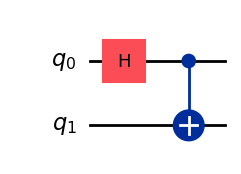

In [6]:
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)
qc.draw(output='mpl')

In [9]:
ZZ = Pauli('ZZ')
ZI = Pauli('ZI')
IZ = Pauli('IZ')
XX = Pauli('XX')
XI = Pauli('XI')
IX = Pauli('IX')
observables = [ZZ, ZI, IZ, XX, XI, IX]
estimator = Estimator()
job = estimator.run([qc] * len(observables), observables)
job.result()

EstimatorResult(values=array([1.        , 0.00585938, 0.00585938, 1.        , 0.00976562,
       0.00976562]), metadata=[{'shots': 1024, 'variance': 0.0, 'simulator_metadata': [{'time_taken': 0.0078078, 'num_bind_params': 1, 'parallel_state_update': 4, 'parallel_shots': 1, 'required_memory_mb': 0, 'input_qubit_map': [[1, 1], [0, 0]], 'method': 'stabilizer', 'device': 'CPU', 'num_qubits': 2, 'sample_measure_time': 0.0004177, 'active_input_qubits': [0, 1], 'num_clbits': 2, 'remapped_qubits': False, 'runtime_parameter_bind': False, 'max_memory_mb': 7886, 'noise': 'ideal', 'measure_sampling': True, 'batched_shots_optimization': False, 'fusion': {'enabled': False}}]}, {'shots': 1024, 'variance': 0.9999656677246094, 'simulator_metadata': [{'time_taken': 0.0078078, 'num_bind_params': 1, 'parallel_state_update': 4, 'parallel_shots': 1, 'required_memory_mb': 0, 'input_qubit_map': [[1, 1], [0, 0]], 'method': 'stabilizer', 'device': 'CPU', 'num_qubits': 2, 'sample_measure_time': 0.0004177, 'activ

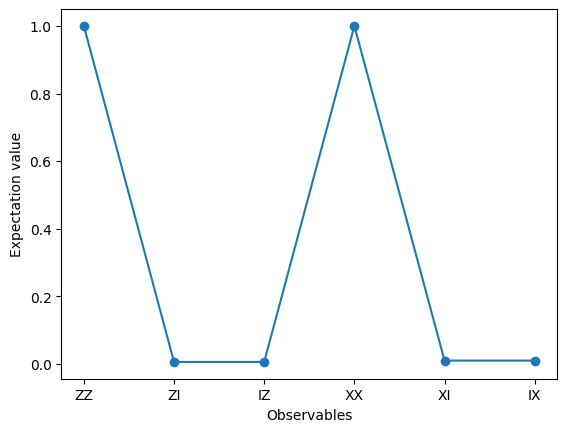

In [10]:
data = ['ZZ', 'ZI', 'IZ', 'XX', 'XI', 'IX']
values = job.result().values
plt.plot(data, values, '-o')
plt.xlabel('Observables')
plt.ylabel('Expectation value')
plt.show()

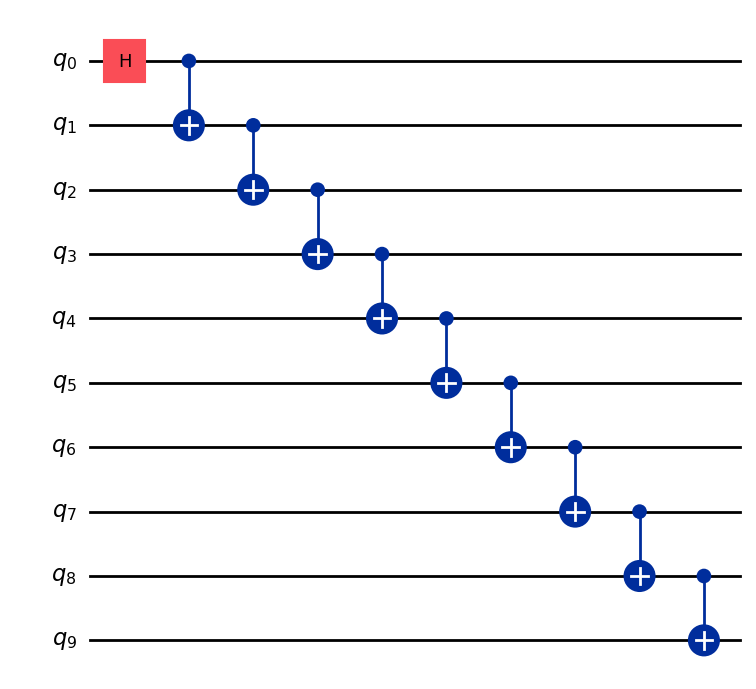

In [11]:
def get_qc_for_n_qubit_GHZ_state(n: int) -> QuantumCircuit:
    qc = QuantumCircuit(n)
    qc.h(0)
    for i in range(n-1):
        qc.cx(i, i+1)
    return qc


n = 10#0
qc = get_qc_for_n_qubit_GHZ_state(n)
qc.draw(output='mpl')

In [12]:
operator_strings = ['Z' + 'I'*i + 'Z' + 'I'*(n-2-i) for i in range (n-1)]
print(operator_strings)
print(len(operator_strings))
operators = [SparsePauliOp(operator_string) for operator_string in operator_strings]

['ZZIIIIIIII', 'ZIZIIIIIII', 'ZIIZIIIIII', 'ZIIIZIIIII', 'ZIIIIZIIII', 'ZIIIIIZIII', 'ZIIIIIIZII', 'ZIIIIIIIZI', 'ZIIIIIIIIZ']
9


In [13]:
pass_manager = generate_preset_pass_manager(optimization_level=1, backend=backend)
qc_transpiled = pass_manager.run(qc)
operators_transpiled_list = [op.apply_layout(qc_transpiled.layout) for op in operators]

```py
options = EstimatorOptions()
options.resilience_level = 1
# options.optimization_level = 0
options.dynamical_decoupling.enable = True
options.dynamical_decoupling.sequence_type = "XY4"
estimator = EstimatorV2(backend, options=options)
job = estimator.run([(qc_transpiled, operators_transpiled_list)])
job_id = job.job_id()
print(job_id)
```

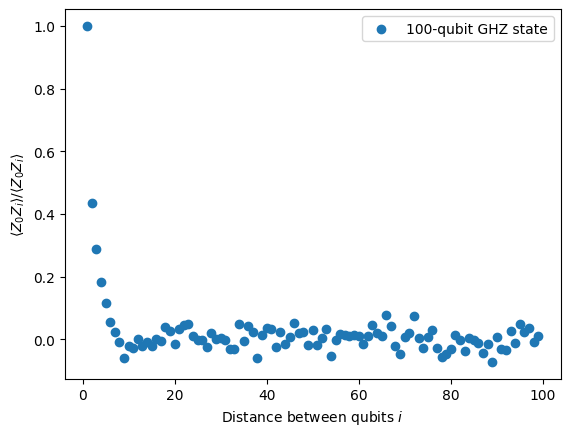

In [14]:
n = 100
operator_strings = ['Z' + 'I'*i + 'Z' + 'I'*(n-2-i) for i in range (n-1)]
operators = [SparsePauliOp(operator_string) for operator_string in operator_strings]

job_id = 'cy0ys7cnrmz000853zag'
job = service.job(job_id)
data = list(range(1, len(operators)+1))
result = job.result()[0]
values = result.data.evs
values = [v/values[0] for v in values]
plt.scatter(data, values, marker='o', label='100-qubit GHZ state')
plt.xlabel('Distance between qubits $i$')
plt.ylabel(r'$\langle Z_0 Z_i \rangle / \langle Z_0 Z_i \rangle$')
plt.legend()
plt.show()

## Solve utility-scale quantum optimization problems
This section follows the "[Solve utility-scale quantum optimization problems](https://learning.quantum.ibm.com/tutorial/quantum-approximate-optimization-algorithm)" section of the IBM Quantum Learning tutorial.

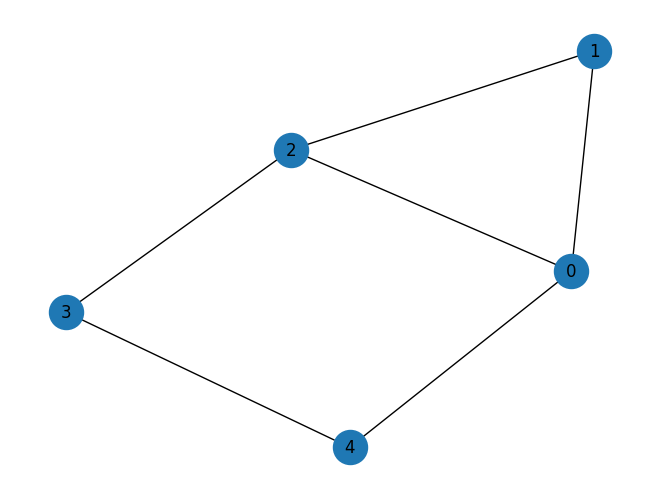

In [15]:
n = 5
graph = rx.PyGraph()
graph.add_nodes_from(np.arange(0, n, 1))
edge_list = [(0, 1, 1.0), (0, 2, 1.0), (0, 4, 1.0), (1, 2, 1.0), (2, 3, 1.0), (3, 4, 1.0)]
graph.add_edges_from(edge_list)
draw_graph(graph, node_size=600, with_labels=True)

In [16]:
def build_max_cut_paulis(graph: rx.PyGraph) -> list[tuple[str, float]]:
    """Convert the graph to Pauli list.

    This function does the inverse of `build_max_cut_graph`
    """
    pauli_list = []
    for edge in list(graph.edge_list()):
        paulis = ["I"] * len(graph)
        paulis[edge[0]], paulis[edge[1]] = "Z", "Z"

        weight = graph.get_edge_data(edge[0], edge[1])

        pauli_list.append(("".join(paulis)[::-1], weight))

    return pauli_list


max_cut_paulis = build_max_cut_paulis(graph)

cost_hamiltonian = SparsePauliOp.from_list(max_cut_paulis)
print("Cost Function Hamiltonian:", cost_hamiltonian)

Cost Function Hamiltonian: SparsePauliOp(['IIIZZ', 'IIZIZ', 'ZIIIZ', 'IIZZI', 'IZZII', 'ZZIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


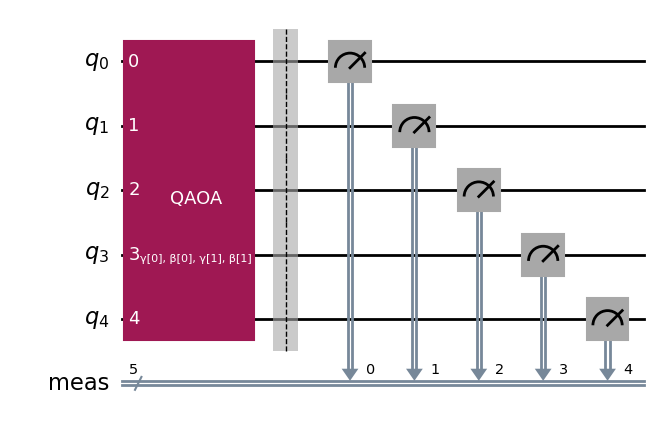

In [17]:
circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=2)
circuit.measure_all()

circuit.draw('mpl')

In [18]:
circuit.parameters

ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(β[1]), ParameterVectorElement(γ[0]), ParameterVectorElement(γ[1])])

```python
service = QiskitRuntimeService(channel='ibm_quantum')
backend = service.least_busy(min_num_qubits=127)
print(backend)
# Create pass manager for transpilation
pm = generate_preset_pass_manager(optimization_level=3,
                                    backend=backend)
candidate_circuit = pm.run(circuit)
candidate_circuit.draw('mpl', fold=False, idle_wires=False)
```

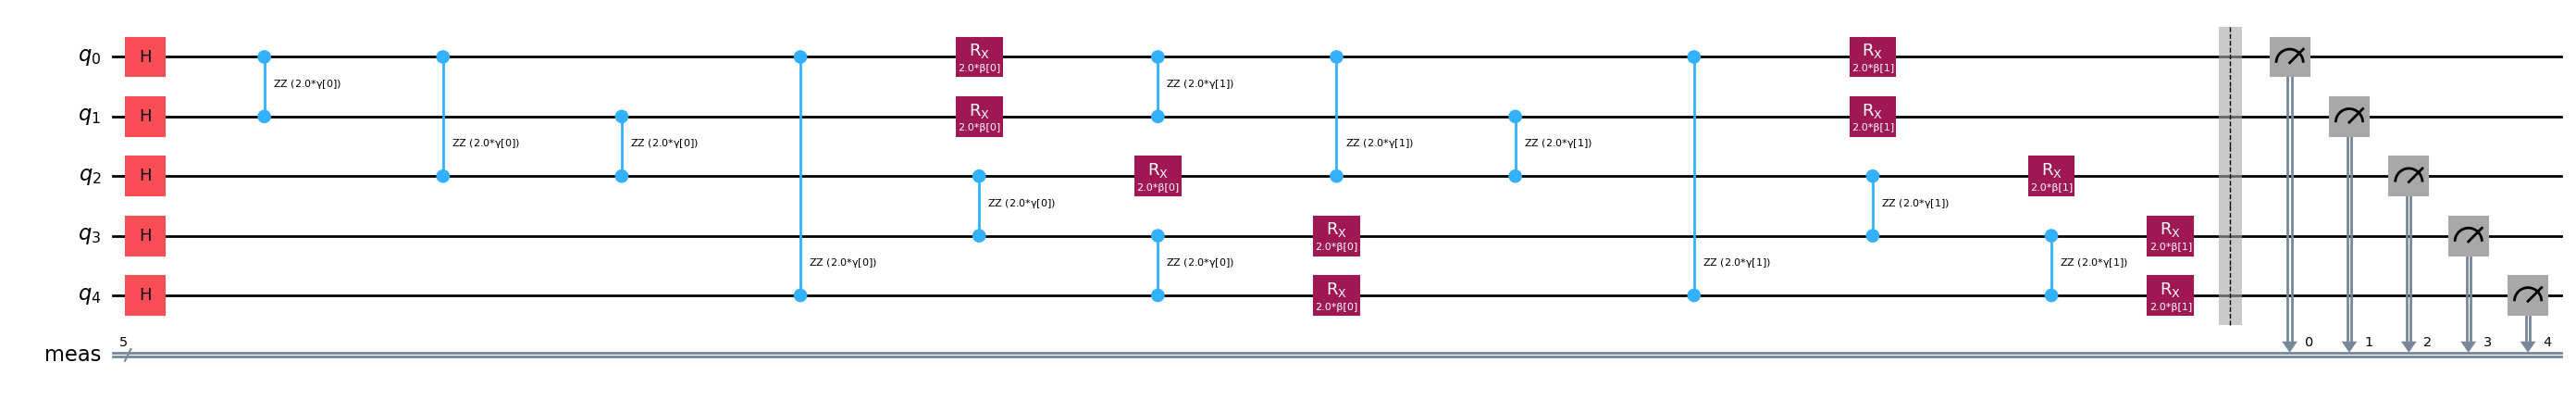

In [19]:
backend = AerSimulator()
pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
candidate_circuit = pm.run(circuit)
candidate_circuit.draw('mpl', fold=False, idle_wires=False)

In [20]:
initial_gamma = np.pi
initial_beta = np.pi/2
init_params = [initial_gamma, initial_beta, initial_gamma, initial_beta]

In [22]:
objective_func_vals = [] # Global variable

def cost_func_estimator(params, ansatz, hamiltonian, estimator):

    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)

    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs

    objective_func_vals.append(cost)

    return cost

with Session(backend=backend) as session:
    # If using qiskit-ibm-runtime<0.24.0, change `mode=` to `session=`
    estimator = EstimatorV2() # mode=session)
    estimator.options.default_shots = 1000

    # Set simple error suppression/mitigation options
    # estimator.options.dynamical_decoupling.enable = True
    # estimator.options.dynamical_decoupling.sequence_type = "XY4"
    # estimator.options.twirling.enable_gates = True
    # estimator.options.twirling.num_randomizations = "auto"

    result = minimize(
        cost_func_estimator,
        init_params,
        args=(candidate_circuit, cost_hamiltonian, estimator),
        method="COBYLA",
        tol=1e-2,
    )
    print(result)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -2.4995004995004995
       x: [ 3.304e+00  2.817e+00  2.532e+00  1.041e+00]
    nfev: 35
   maxcv: 0.0


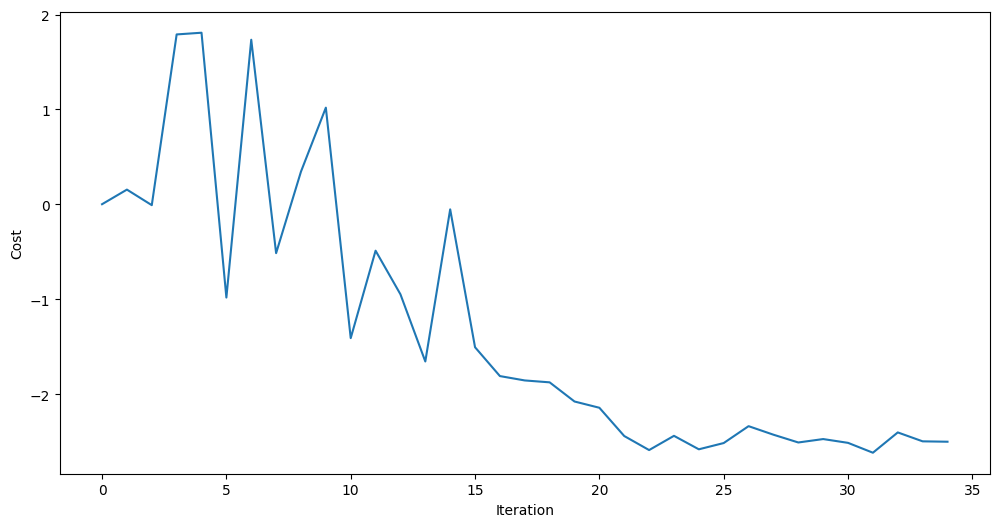

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

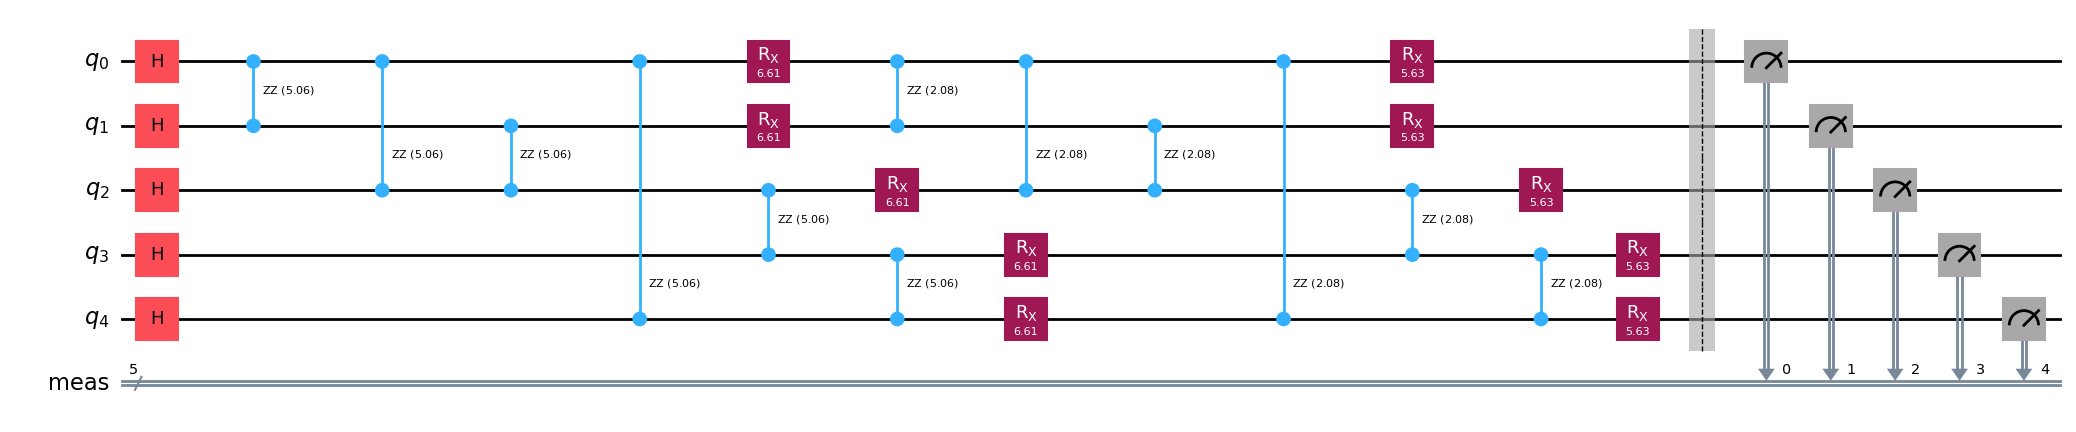

In [24]:
optimized_circuit = candidate_circuit.assign_parameters(result.x)
optimized_circuit.draw('mpl', fold=False, idle_wires=False)

In [25]:
# If using qiskit-ibm-runtime<0.24.0, change `mode=` to `backend=`
sampler = Sampler() # mode=backend)
sampler.options.default_shots = 10000

# Set simple error suppression/mitigation options
# sampler.options.dynamical_decoupling.enable = True
# sampler.options.dynamical_decoupling.sequence_type = "XY4"
# sampler.options.twirling.enable_gates = True
# sampler.options.twirling.num_randomizations = "auto"

pub= (optimized_circuit, )
job = sampler.run([pub], shots=int(1e4))
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val/shots for key, val in counts_int.items()}
final_distribution_bin = {key: val/shots for key, val in counts_bin.items()}
print(final_distribution_int)

{22: 0.1286, 18: 0.0545, 13: 0.0558, 11: 0.1319, 30: 0.0055, 9: 0.1333, 10: 0.0548, 5: 0.053, 21: 0.0565, 24: 0.0077, 20: 0.1274, 28: 0.0046, 29: 0.0086, 26: 0.0485, 14: 0.0159, 0: 0.0078, 2: 0.0078, 8: 0.003, 19: 0.0142, 23: 0.0032, 31: 0.0084, 12: 0.0138, 17: 0.0141, 25: 0.0039, 15: 0.0031, 3: 0.0062, 16: 0.0026, 1: 0.004, 7: 0.0081, 27: 0.0045, 6: 0.005, 4: 0.0037}


In [26]:
# auxiliary functions to sample most likely bitstring
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely, len(graph))
most_likely_bitstring.reverse()

print("Result bitstring:", most_likely_bitstring)

Result bitstring: [1, 0, 0, 1, 0]


/tmp/ipykernel_1448/1088284304.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.get_children()[int(p)].set_color("tab:purple")


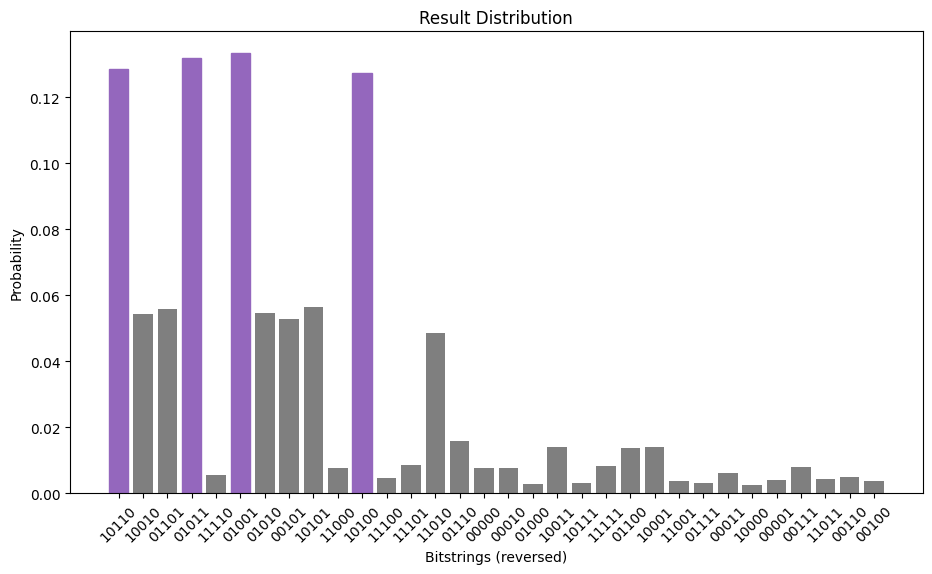

In [27]:
final_bits = final_distribution_bin
values = np.abs(list(final_bits.values()))
top_4_values = sorted(values, reverse=True)[:4]
positions = []
for value in top_4_values:
    positions.append(np.where(values == value)[0])
fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=45)
plt.title("Result Distribution")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")
ax.bar(list(final_bits.keys()), list(final_bits.values()), color="tab:grey")
for p in positions:
    ax.get_children()[int(p)].set_color("tab:purple")
plt.show()

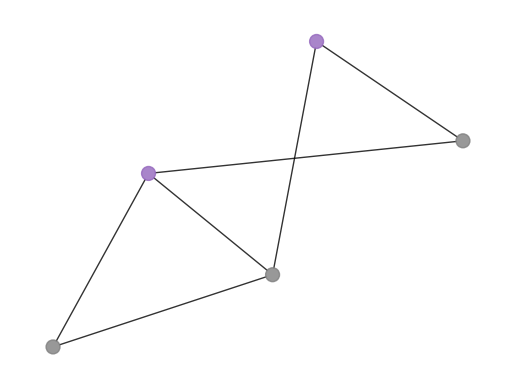

In [28]:
# auxiliary function to plot graphs
def plot_result(G, x):
    colors = ["tab:grey" if i == 0 else "tab:purple" for i in x]
    pos, default_axes = rx.spring_layout(G), plt.axes(frameon=True)
    rx.visualization.mpl_draw(G, node_color=colors, node_size=100, alpha=0.8, pos=pos)


plot_result(graph, most_likely_bitstring)

In [29]:
def evaluate_sample(x: Sequence[int], graph: rx.PyGraph) -> float:
    assert len(x) == len(list(graph.nodes())), "The length of x must coincide with the number of nodes in the graph."
    return sum(x[u] * (1 - x[v]) + x[v] * (1 - x[u]) for u, v in list(graph.edge_list()))


cut_value = evaluate_sample(most_likely_bitstring, graph)
print('The value of the cut is:', cut_value)

The value of the cut is: 5


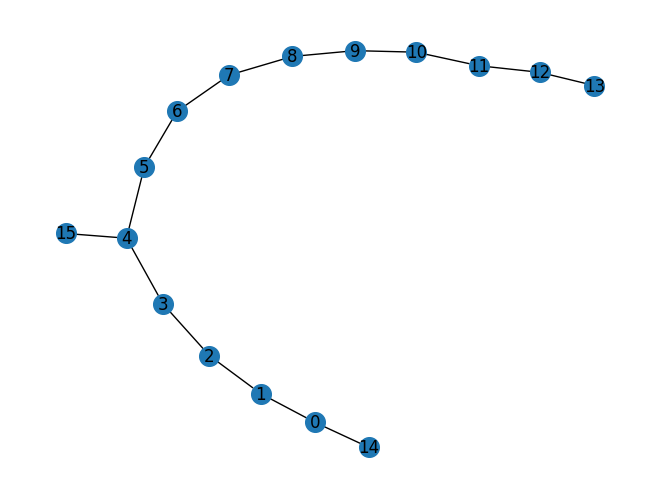

In [68]:
backend = service.least_busy(min_num_qubits=127)

n = 16  # Number of nodes in graph
graph_100 = rx.PyGraph()
graph_100.add_nodes_from(np.arange(0, n, 1))
elist = []
for edge in backend.coupling_map:
    if edge[0] < n and edge[1] < n:
        elist.append((edge[0], edge[1], 1.0))
graph_100.add_edges_from(elist)
draw_graph(graph_100, node_size=200, with_labels=True, width=1)

In [69]:
max_cut_paulis_100 = build_max_cut_paulis(graph_100)

cost_hamiltonian_100 = SparsePauliOp.from_list(max_cut_paulis_100)
print("Cost Function Hamiltonian:", cost_hamiltonian_100)

Cost Function Hamiltonian: SparsePauliOp(['IIIIIIIIIIIIIIZZ', 'IZIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIZZI', 'IIIIIIIIIIIIZZII', 'IIIIIIIIIIIZZIII', 'ZIIIIIIIIIIZIIII', 'IIIIIIIIIIZZIIII', 'IIIIIIIIIZZIIIII', 'IIIIIIIIZZIIIIII', 'IIIIIIIZZIIIIIII', 'IIIIIIZZIIIIIIII', 'IIIIIZZIIIIIIIII', 'IIIIZZIIIIIIIIII', 'IIIZZIIIIIIIIIII', 'IIZZIIIIIIIIIIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


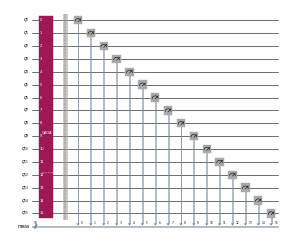

In [70]:
circuit_100 = QAOAAnsatz(cost_operator=cost_hamiltonian_100, reps=1)
circuit_100.measure_all()

circuit_100.draw('mpl', fold=False, scale=0.2, idle_wires=False)

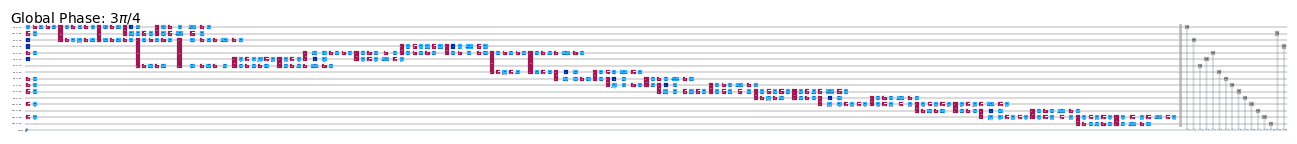

In [71]:
backend = AerSimulator.from_backend(backend)
pm = generate_preset_pass_manager(optimization_level=3,
                                    backend=backend)

candidate_circuit_100 = pm.run(circuit_100)
candidate_circuit_100.draw('mpl', fold=False, scale=0.1, idle_wires=False)

In [ ]:
initial_gamma = np.pi
initial_beta = np.pi/2
init_params = [initial_gamma, initial_beta]

objective_func_vals = [] # Global variable
with Session(backend=backend) as session:
    # If using qiskit-ibm-runtime<0.24.0, change `mode=` to `session=`
    estimator = EstimatorV2(mode=session)

    estimator.options.default_shots = 1000

    # Set simple error suppression/mitigation options
    estimator.options.dynamical_decoupling.enable = True
    estimator.options.dynamical_decoupling.sequence_type = "XY4"
    estimator.options.twirling.enable_gates = True
    estimator.options.twirling.num_randomizations = "auto"

    result = minimize(
        cost_func_estimator,
        init_params,
        args=(candidate_circuit_100, cost_hamiltonian_100, estimator),
        method="COBYLA",
    )
    print(result)

/home/pfischer/miniconda3/envs/py311_qiskit/lib/python3.11/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:268: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
/home/pfischer/miniconda3/envs/py311_qiskit/lib/python3.11/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:268: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
/home/pfischer/miniconda3/envs/py311_qiskit/lib/python3.11/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:268: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequen

In [51]:
optimized_circuit_100 = candidate_circuit_100.assign_parameters(result.x)
optimized_circuit_100.draw('mpl', fold=False, idle_wires=False)

ValueError: Mismatching number of values and parameters. For partial binding please pass a dictionary of {parameter: value} pairs.

In [54]:
# If using qiskit-ibm-runtime<0.24.0, change `mode=` to `backend=`
sampler = Sampler() # mode=backend)
sampler.options.default_shots = 10000

# Set simple error suppression/mitigation options
# sampler.options.dynamical_decoupling.enable = True
# sampler.options.dynamical_decoupling.sequence_type = "XY4"
# sampler.options.twirling.enable_gates = True
# sampler.options.twirling.num_randomizations = "auto"


pub= (optimized_circuit_100, )
job = sampler.run([pub], shots=int(1e4))

counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_100_int = {key: val/shots for key, val in counts_int.items()}

NameError: name 'optimized_circuit_100' is not defined

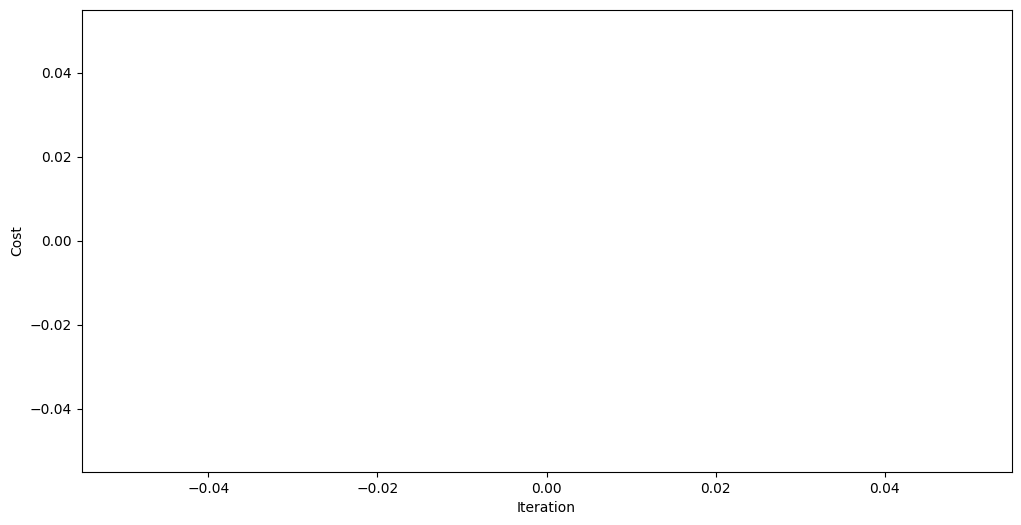

In [55]:
plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

In [56]:
_PARITY = np.array([-1 if bin(i).count("1") % 2 else 1 for i in range(256)], dtype=np.complex128)


def evaluate_sparse_pauli(state: int, observable: SparsePauliOp) -> complex:
    """Utility for the evaluation of the expectation value of a measured state."""
    packed_uint8 = np.packbits(observable.paulis.z, axis=1, bitorder="little")
    state_bytes = np.frombuffer(state.to_bytes(packed_uint8.shape[1], "little"), dtype=np.uint8)
    reduced = np.bitwise_xor.reduce(packed_uint8 & state_bytes, axis=1)
    return np.sum(observable.coeffs * _PARITY[reduced])

def best_solution(samples, hamiltonian):
    """Find solution with lowest cost"""
    min_cost = 1000
    min_sol = None
    for bit_str in samples.keys():
        # Qiskit use little endian hence the [::-1]
        candidate_sol = int(bit_str)
        # fval = qp.objective.evaluate(candidate_sol)
        fval = evaluate_sparse_pauli(candidate_sol, hamiltonian).real
        if fval <= min_cost:
            min_sol = candidate_sol

    return min_sol

best_sol_100 = best_solution(final_distribution_100_int, cost_hamiltonian_100)
best_sol_bitstring_100 = to_bitstring(int(best_sol_100), len(graph_100))
best_sol_bitstring_100.reverse()

print("Result bitstring:", best_sol_bitstring_100)

NameError: name 'final_distribution_100_int' is not defined

In [57]:
plot_result(graph_100, best_sol_bitstring_100)

NameError: name 'best_sol_bitstring_100' is not defined

In [58]:
cut_value_100= evaluate_sample(best_sol_bitstring_100, graph_100)
print('The value of the cut is:', cut_value_100)

NameError: name 'best_sol_bitstring_100' is not defined

In [61]:
# auxiliary function to help plot cumulative distribution functions
def _plot_cdf(objective_values: dict, ax, color):
    x_vals = sorted(objective_values.keys(), reverse=True)
    y_vals = np.cumsum([objective_values[x] for x in x_vals])
    ax.plot(x_vals, y_vals, color=color)


def plot_cdf(dist, ax, title):
    _plot_cdf(dist, ax, "C1",)
    ax.vlines(min(list(dist.keys())), 0, 1, "C1", linestyle="--")

    ax.set_title(title)
    ax.set_xlabel("Objective function value")
    ax.set_ylabel("Cumulative distribution function")
    ax.grid(alpha=0.3)

# auxiliary function to convert bit-strings to objective values
def samples_to_objective_values(samples, hamiltonian):
    """Convert the samples to values of the objective function."""

    objective_values = defaultdict(float)
    for bit_str, prob in samples.items():
        candidate_sol = int(bit_str)
        fval = evaluate_sparse_pauli(candidate_sol, hamiltonian).real
        objective_values[fval] += prob

    return objective_values

NameError: name 'result_dist' is not defined

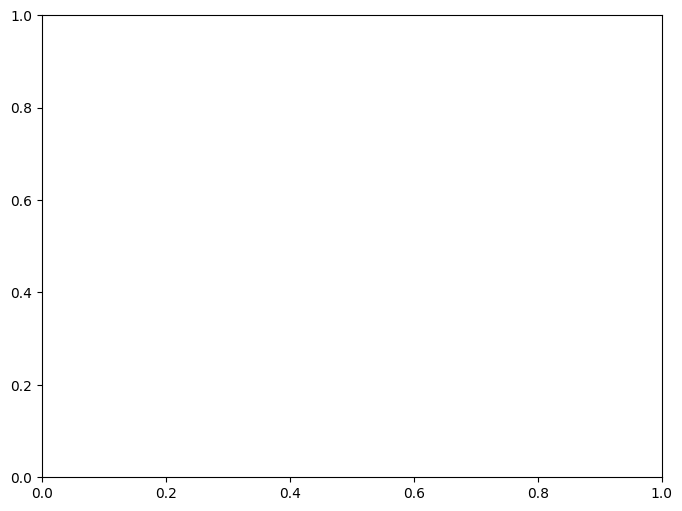

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
plot_cdf(result_dist, ax, "Eagle device")